In [1]:
import glob

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [5]:
size = "large"

backbones = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
encoder = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=f"dinov2_{backbones[size]}").cuda()

patch_size = encoder.patch_size
patch_h, patch_w = 14*50//patch_size, 14*50//patch_size
background_threshold = 0.5

patch_size, patch_h

Using cache found in /home/rob/.cache/torch/hub/facebookresearch_dinov2_main


(14, 50)

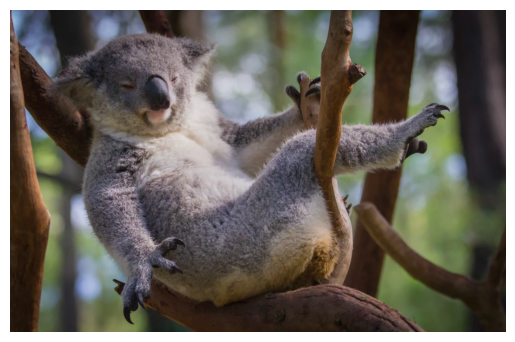

In [6]:
samples = glob.glob('assets/*.png')
images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in samples]

plt.imshow(images[0])
plt.axis('off')
plt.show()

In [7]:
def transform(img):
    img = cv2.resize(img, (patch_h * patch_size, patch_w * patch_size)) / 255
    img = (img - np.array([0.485, 0.456, 0.406]))/ np.array([0.229, 0.24, 0.225])
    img = img.transpose(2, 0, 1)
    return np.expand_dims(img, 0).astype(np.float32)

transformed_images = [transform(img) for img in images]

In [8]:
x = torch.tensor(np.concatenate(transformed_images)).cuda()
features_dict = encoder.forward_features(x)
features = features_dict['x_norm_patchtokens'].detach().cpu().numpy()
features.shape

/home/rob/miniconda3/envs/vit/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


(4, 2500, 1024)

In [9]:
patch_features = features.reshape(len(images) * patch_h * patch_w, -1)
patch_features.shape

(10000, 1024)

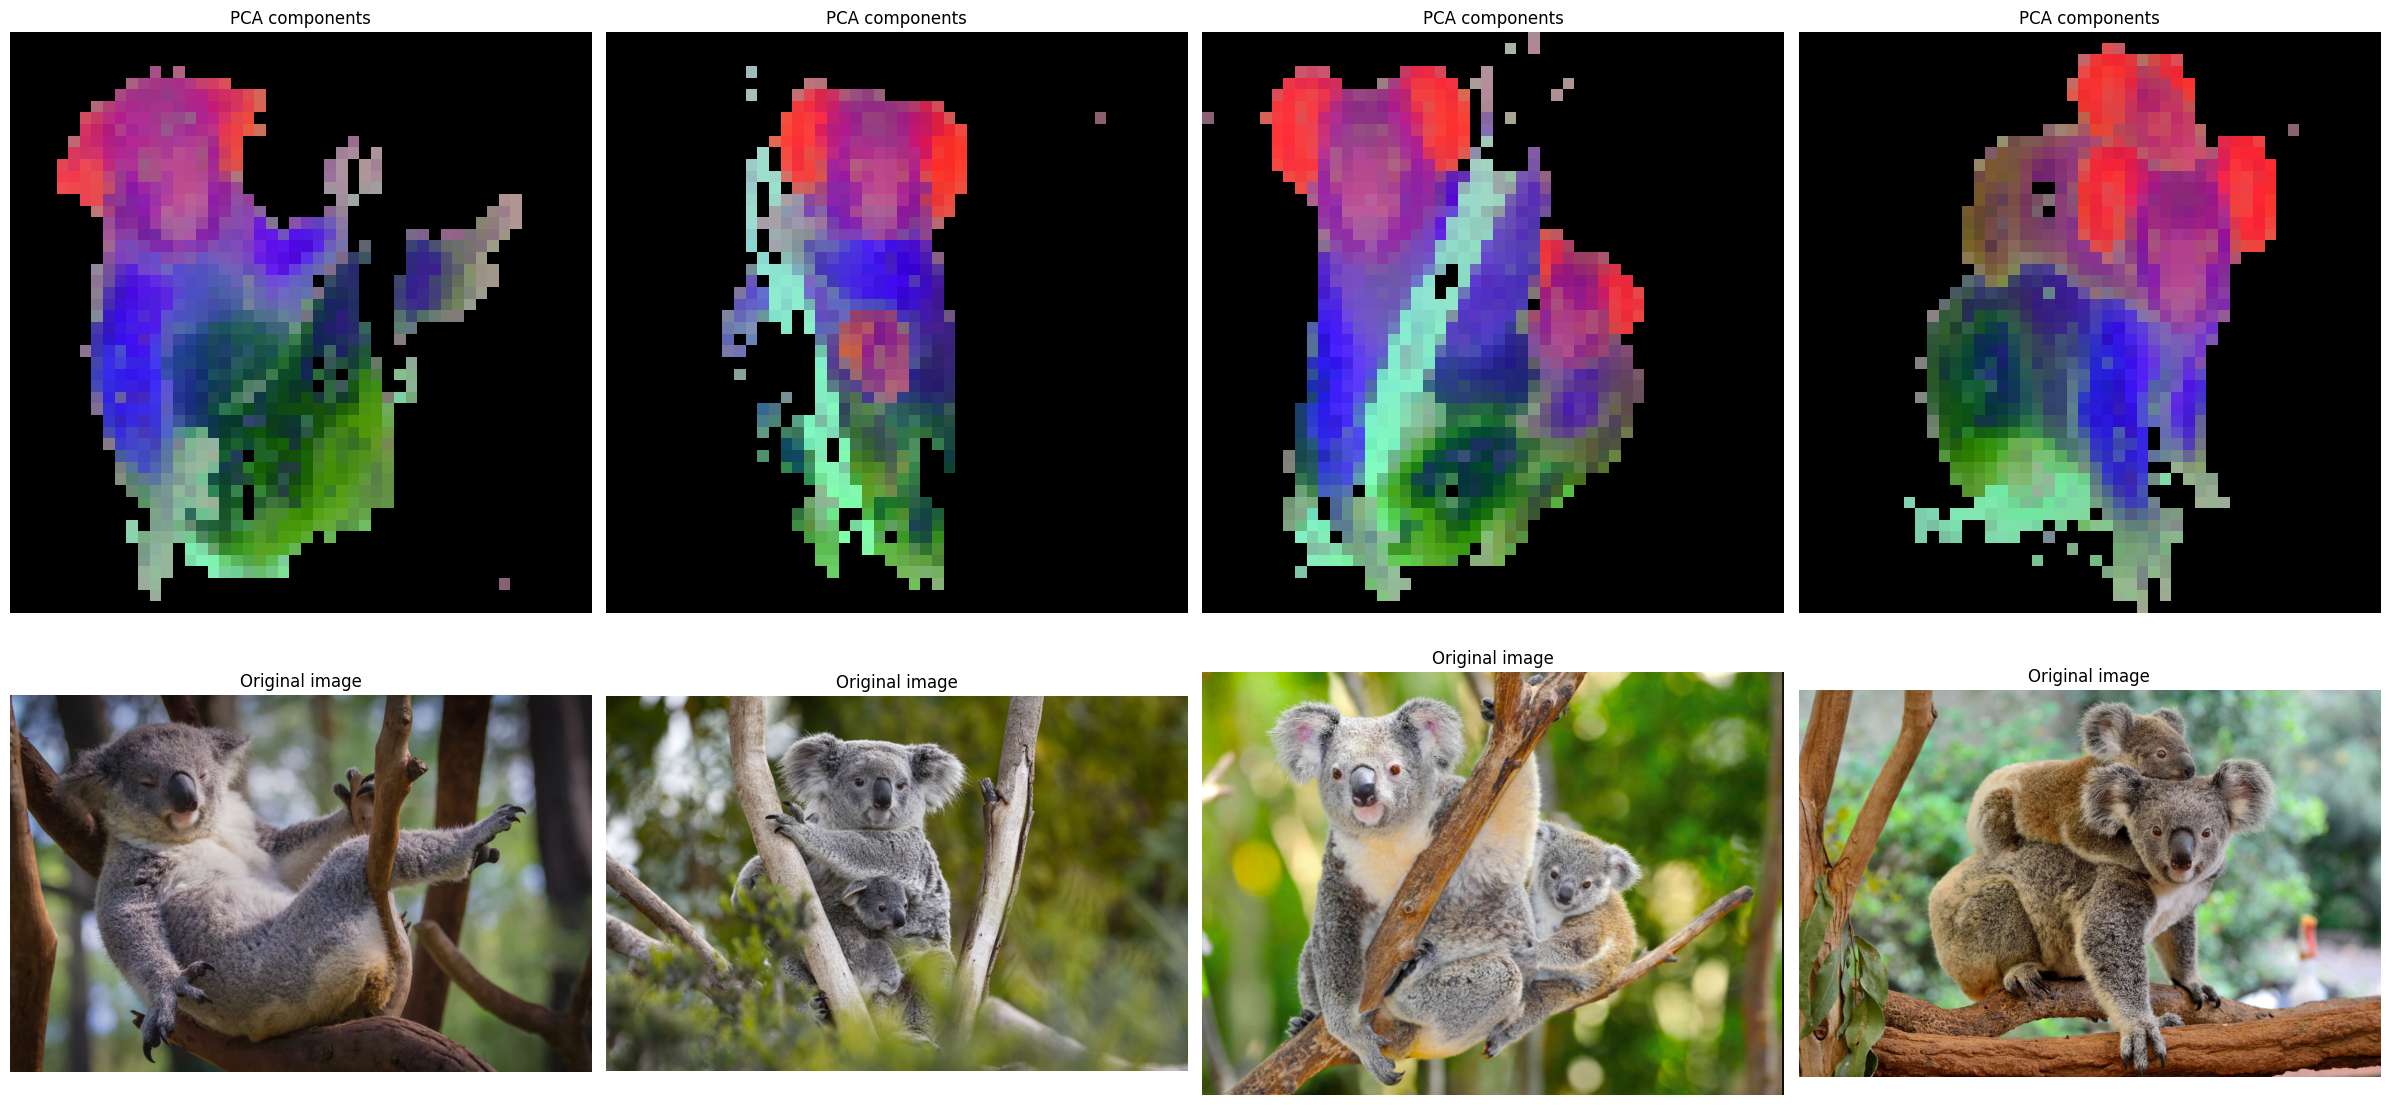

In [11]:
pca = PCA(n_components=3)
scaler = MinMaxScaler(clip=True)

# First fit to seperate background and foreground
pca.fit(patch_features)
pca_features = pca.transform(patch_features)

# MinMax Scaling
scaler.fit(pca_features)
pca_features = scaler.transform(pca_features)

pca_background = pca_features[:, 0] < background_threshold
pca_foreground = ~pca_background

# Second fit for the object
pca.fit(patch_features[pca_foreground])
pca_features_rem = pca.transform(patch_features[pca_foreground])

scaler.fit(pca_features_rem)
pca_features_rem = scaler.transform(pca_features_rem)

pca_features_rgb = np.zeros((len(images) * patch_h * patch_w, 3))
pca_features_rgb[pca_background] = 0
pca_features_rgb[pca_foreground] = pca_features_rem
pca_features_rgb = pca_features_rgb.reshape(len(images), patch_h, patch_w, 3)


fig, axes = plt.subplots(2, len(images), figsize=(6 * len(images), 12))

for i in range(len(images)):
    axes[0, i].imshow(pca_features_rgb[i])
    axes[0, i].set_title(f'PCA components')
    axes[0, i].axis('off')

    # Plot original images
    axes[1, i].imshow(images[i])
    axes[1, i].set_title(f'Original image')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()